## Downstream Notebook
1. Loading the ensemble model using weights saved during the training process
2. Processing the image
3. Calculating a severity score

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random

In [2]:
folder_path = "../../custom_data"
classes = ["alligator crack", "edge crack", "longitudinal cracking", "patching", "rutting","transverse cracking"]

image_files = []
for file in os.listdir(folder_path):
    if file.endswith(".jpg"):
        image_files.append(os.path.join(folder_path, file))
    #endif
#endfor

len(image_files)

8132

In [3]:
def load_yolo(weights_files, cfg_file, names_files):
    nets = []
    classes_list = []
    output_layers_list = []
    colors_list = []

    for weights_file, names_file in zip(weights_files, names_files):
        net = cv2.dnn.readNet(weights_file, cfg_file)
        nets.append(net)

        with open(names_file, "r") as f:
            classes = [line.strip() for line in f.readlines()]
        classes_list.append(classes)

        layer_names = net.getLayerNames()
        output_layers = []
        for i in net.getUnconnectedOutLayers():
            output_layers.append(layer_names[i-1])
        #endfor

        output_layers_list.append(output_layers)

        colors = np.random.uniform(0, 255, size=(len(classes), 3))
        colors_list.append(colors)
    #endfor

    return nets, classes_list, colors_list, output_layers_list
#enddef

def detect_objects(img, net, outputLayers):
    blob = cv2.dnn.blobFromImage(img, scalefactor=0.00392, size=(416, 416), mean=(0, 0, 0), swapRB=True, crop=False)
    net.setInput(blob)
    outputs = net.forward(outputLayers)
    return blob, outputs
#enddef

def get_box_dimensions(outputs, height, width):
    boxes = []
    confs = []
    class_ids = []
    for output in outputs:
        for detect in output:
            scores = detect[5:]
            class_id = np.argmax(scores)
            conf = scores[class_id]
            if conf > 0.2:
                center_x = int(detect[0] * width)
                center_y = int(detect[1] * height)
                w = int(detect[2] * width)
                h = int(detect[3] * height)
                x = int(center_x - w/2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confs.append(float(conf))
                class_ids.append(class_id)
            #endif
        #endfor
    #endfor
    return boxes, confs, class_ids
#enddef

In [44]:
def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    x_left = max(x1, x2)
    y_top = max(y1, y2)
    x_right = min(x1 + w1, x2 + w2)
    y_bottom = min(y1 + h1, y2 + h2)
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    #endif
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    box1_area = w1 * h1
    box2_area = w2 * h2
    
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou
#enddef

def draw_labels_iou(boxes, confs, colors, class_ids, classes, img, iou_threshold=0.1):
    font = cv2.FONT_HERSHEY_PLAIN
    bbox_info_list = []
    
    drawing_occurred = False
    
    for i in range(len(boxes)):
        if boxes[i] is None:
            continue
        
        if isinstance(boxes[i], (list, tuple)) and len(boxes[i]) == 4:
            x_i, y_i, w_i, h_i = boxes[i]
            label_i = str(classes[class_ids[i]])
            color_i = (0, 255, 0)  # Default color
            
            for j in range(i + 1, len(boxes)):
                if boxes[j] is None or class_ids[j] != class_ids[i]:
                    continue
                
                if isinstance(boxes[j], (list, tuple)) and len(boxes[j]) == 4:
                    x_j, y_j, w_j, h_j = boxes[j]
                    iou = calculate_iou((x_i, y_i, w_i, h_i), (x_j, y_j, w_j, h_j))
                    
                    if iou > iou_threshold:
                        if confs[i] > confs[j]:
                            boxes[j] = None
                        else:
                            boxes[i] = None
                            break
                        #endif
                    #endif
                #endif
            #endfor
            else:
                drawing_occurred = True
                cv2.rectangle(img, (x_i, y_i), (x_i + w_i, y_i + h_i), color_i, 2)
                cv2.putText(img, label_i, (x_i, y_i - 5), font, 1, color_i, 1)
                
                area_i = w_i * h_i
                perimeter_i = 2 * (w_i + h_i)
                
                bbox_info = {
                    "class": label_i,
                    "area": area_i,
                    "perimeter": perimeter_i
                }
                
                bbox_info_list.append(bbox_info)
            #endif
        #endif
    #endfor
    
    if not drawing_occurred:
        return img, []
    else:
        return img, bbox_info_list
    #endif
#enddef

In [39]:
def get_severity_score(bbox_info_list, total_bboxes, image_size):
    thresholds = {
        'low': 0.6 * image_size,
        'medium': 0.8 * image_size
    }
    
    total_area = sum(bbox_info["area"] for bbox_info in bbox_info_list)
    total_perimeter = sum(bbox_info["perimeter"] for bbox_info in bbox_info_list)
    
    severity_score = 0
    
    if total_bboxes < thresholds['low']:
        severity_score += 1
    
    if total_area > 0.5 * (image_size ** 2):
        severity_score += 1
    #endif
    
    if total_perimeter > 0.1 * (image_size * 2):
        severity_score += 1
    #endif
    
    severity_text = ''
    if severity_score <= 1:
        severity_text = 'Low'
    elif severity_score == 2:
        severity_text = 'Medium'
    else:
        severity_text = 'High'
    #endif
    
    return {'score': severity_score, 'text': severity_text}
#enddef

In [31]:
def preprocess_image(image):
    return image
#enddef

def load_image(img_path):
    img = cv2.imread(img_path)
    # img = cv2.resize(img, None, fx=0.4, fy=0.4)
    height, width, channels = img.shape
    return img, height, width, channels
#enddef

def process_image(image_path, loaded_yolo):
    nets, classes_list, colors_list, output_layers_list = loaded_yolo
    image, height, width, channels = load_image(image_path)

    preprocessed_image = preprocess_image(image)
    height, width, _ = preprocessed_image.shape
    
    combined_boxes = []
    combined_confs = []
    combined_class_ids = []
    
    for net, classes, colors, output_layers in zip(nets, classes_list, colors_list, output_layers_list):
        blob, outputs = detect_objects(preprocessed_image, net, output_layers)
        boxes, confs, class_ids = get_box_dimensions(outputs, height, width)
        combined_boxes.extend(boxes)
        combined_confs.extend(confs)
        combined_class_ids.extend(class_ids)
    #endfor
    
    preprocessed_image, bbox_info_list = draw_labels_iou(combined_boxes, combined_confs, colors_list[0], combined_class_ids, classes_list[0], preprocessed_image)
    severity_score = get_severity_score(bbox_info_list, len(bbox_info_list), width)
    print(bbox_info_list)
    print(severity_score)
    
    plt.figure(figsize=(10, 8)) 
    plt.imshow(cv2.cvtColor(preprocessed_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    
    # return preprocessed_image, drawn_bboxes
#enddef

In [46]:
model_configs = {
    "config1": ["../colab_weights/yolov3-custom-second_last (8).weights"],
    "config2": ["../colab_weights/yolov3-custom-second_last (10).weights"],
    "config3": ["../colab_weights/yolov3-custom-second_last (13).weights"],
    "config_combined": [
        "../colab_weights/yolov3-custom-second_last (8).weights",
        "../colab_weights/yolov3-custom-second_last (10).weights",
        "../colab_weights/yolov3-custom-second_last (13).weights"
    ],
}

cfg_file = "../yolov3-custom-second.cfg"

loaded_yolo_config_combined = load_yolo(model_configs["config_combined"], cfg_file, [f"../classes.names" for i in range(len(model_configs["config_combined"]))])

[{'class': 'alligator cracking', 'area': 194304, 'perimeter': 1792}, {'class': 'transverse cracking', 'area': 21588, 'perimeter': 682}, {'class': 'transverse cracking', 'area': 2300, 'perimeter': 270}]
{'score': 3, 'text': 'High'}


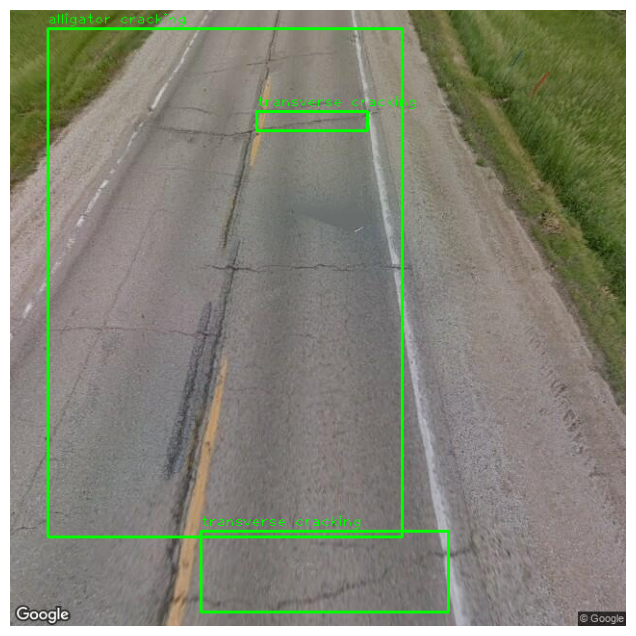

[{'class': 'transverse cracking', 'area': 5335, 'perimeter': 304}, {'class': 'edge cracking', 'area': 1274, 'perimeter': 150}, {'class': 'transverse cracking', 'area': 2325, 'perimeter': 236}]
{'score': 2, 'text': 'Medium'}


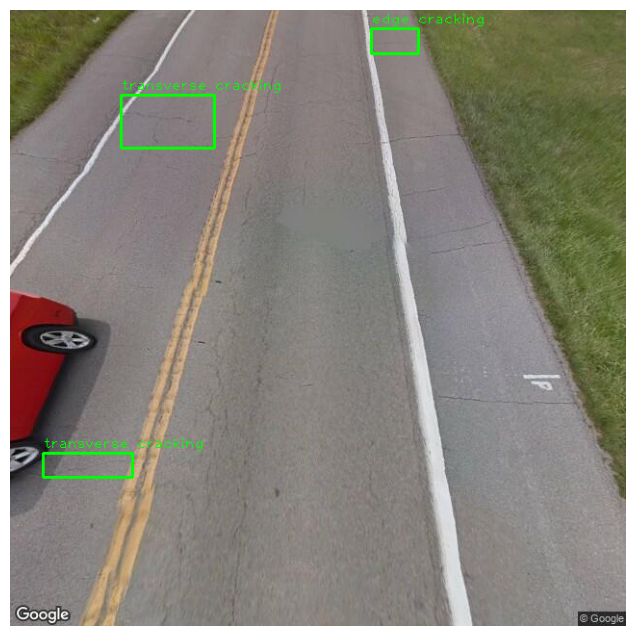

[{'class': 'transverse cracking', 'area': 5247, 'perimeter': 304}, {'class': 'transverse cracking', 'area': 5310, 'perimeter': 326}, {'class': 'transverse cracking', 'area': 6766, 'perimeter': 466}, {'class': 'transverse cracking', 'area': 5642, 'perimeter': 306}, {'class': 'transverse cracking', 'area': 28296, 'perimeter': 740}]
{'score': 2, 'text': 'Medium'}


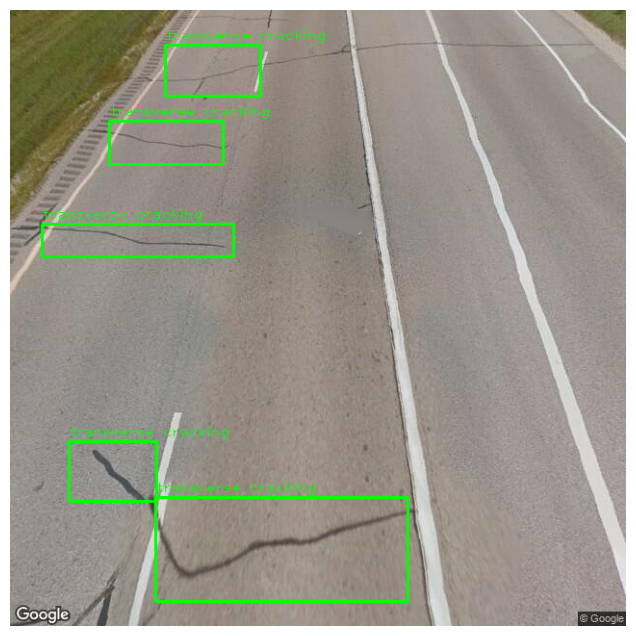

In [47]:
random_images = random.sample(image_files, 3)

for image_path in random_images:
    processed_image = process_image(image_path, loaded_yolo_config_combined)
#endfor